In [67]:
from optimizers import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt

### Helper functions

In [68]:
_infty = 1e16
_zero = 1e-32

def remove_nans_infs_and_zeros(arr):
    arr = np.array(arr)
    arr[np.isnan(arr)] = _infty
    arr[np.isinf(arr)] = _infty
    arr[arr > _infty] = _infty
    arr[arr == 0] = _zero
    arr[arr < _zero] = _zero
    return arr

# A neural network

In [69]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [70]:
def F(x, p, layers):
    assert x.shape[0] == layers[0]
    
    W = []
    b = []
    index = 0
    for i in range(len(layers) - 1):
        W.append(p[index:index + layers[i] * layers[i + 1]].reshape((layers[i + 1], layers[i])))
        index += layers[i] * layers[i + 1]
    for i in range(len(layers) - 1):
        b.append(p[index:index + layers[i + 1]])
        index += layers[i + 1]
    
    a = x
    for i in range(len(layers) - 1):
        a = sigmoid(W[i] @ a + b[i])
    y = a
    
    assert y.shape[0] == layers[-1]
    
    return y

In [71]:
def f(p, layers, X, Y):
    res = np.array([np.linalg.norm(F(x, p, layers) - y) for x, y in zip(X, Y)])
    return res

In [72]:
def grad_C(p, layers, x, y):
    assert x.shape[0] == layers[0]
    assert y.shape[0] == layers[-1]
    
    W = []
    b = []
    index = 0
    for i in range(len(layers) - 1):
        W.append(p[index:index + layers[i] * layers[i + 1]].reshape((layers[i + 1], layers[i])))
        index += layers[i] * layers[i + 1]
    for i in range(len(layers) - 1):
        b.append(p[index:index + layers[i + 1]])
        index += layers[i + 1]
    
    a = [x]
    z = []
    for i in range(len(layers) - 1):
        z.append(W[i] @ a[i] + b[i])
        a.append(sigmoid(z[i]))
    
    delta = [sigmoid(z[-1]) * (1 - sigmoid(z[-1])) * (a[-1] - y)]
    for i in range(len(layers) - 2, 0, -1):
        delta.append(sigmoid(z[i - 1]) * (1 - sigmoid(z[i - 1])) * (W[i].T @ delta[-1]))
    delta = delta[::-1]
    
    grad_W = []
    for i in range(len(layers) - 1):
        grad_W.append(delta[i].reshape((layers[i + 1], 1)) @ a[i].reshape((1, layers[i])))
    
    grad_b = delta
    
    grad = np.concatenate(([grad_W[i].flatten() for i in range(len(grad_W))] + [grad_b[i] for i in range(len(grad_b))]))
    
    assert grad.shape == p.shape
    
    return grad

In [73]:
def hess_C(p, layers, x, y):
    assert x.shape[0] == layers[0]
    assert y.shape[0] == layers[-1]
    
    W = []
    b = []
    index = 0
    for i in range(len(layers) - 1):
        W.append(p[index:index + layers[i] * layers[i + 1]].reshape((layers[i + 1], layers[i])))
        index += layers[i] * layers[i + 1]
    for i in range(len(layers) - 1):
        b.append(p[index:index + layers[i + 1]])
        index += layers[i + 1]
    
    a = [x]
    z = []
    for i in range(len(layers) - 1):
        z.append(W[i] @ a[i] + b[i])
        a.append(sigmoid(z[i]))
    
    delta = [sigmoid(z[-1]) * (1 - sigmoid(z[-1])) * (a[-1] - y)]
    for i in range(len(layers) - 2, 0, -1):
        delta.append(sigmoid(z[i - 1]) * (1 - sigmoid(z[i - 1])) * (W[i].T @ delta[-1]))
    delta = delta[::-1]
    
    grad_W = []
    for i in range(len(layers) - 1):
        grad_W.append(delta[i].reshape((layers[i + 1], 1)) @ a[i].reshape((1, layers[i])))
    
    grad_b = delta
    
    grad = np.concatenate(([grad_W[i].flatten() for i in range(len(grad_W))] + [grad_b[i] for i in range(len(grad_b))]))
    
    hess_W = []
    for i in range(len(layers) - 1):
        hess_W.append(np.zeros((layers[i + 1] * layers[i], layers[i + 1] * layers[i])))
        for j in range(layers[i + 1]):
            for k in range(layers[i]):
                hess_W[i][j * layers[i] + k][j * layers[i] + k] = sigmoid(z[i][j]) * (1 - sigmoid(z[i][j])) * a[i][k]
    
    hess_b = []
    for i in range(len(layers) - 1):
        hess_b.append(np.zeros((layers[i + 1], layers[i + 1])))
        for j in range(layers[i + 1]):
            hess_b[i][j][j] = sigmoid(z[i][j]) * (1 - sigmoid(z[i][j]))

    hess = np.zeros((p.shape[0], p.shape[0]))
    index = 0
    for i in range(len(layers) - 1):
        hess[index:index + layers[i + 1] * layers[i], index:index + layers[i + 1] * layers[i]] = hess_W[i]
        index += layers[i + 1] * layers[i]
    for i in range(len(layers) - 1):
        hess[index:index + layers[i + 1], index:index + layers[i + 1]] = hess_b[i]
        index += layers[i + 1]

    assert hess.shape == (p.shape[0], p.shape[0])

    return hess

# Data

$X_i$ - random 2 dimentional vector with entries from -50 to 50

$Y_i$ - sum of entries of $X$ is greater than or equal 0

In [74]:
num_samples = 50
X = 100 * np.random.rand(num_samples, 2) - 50
Y = np.vstack(((X[:, 0] + X[:, 1] >= 0).astype(float), (X[:, 0] + X[:, 1] < 0).astype(float))).T
X[:5, :], Y[:5, :]

(array([[-33.1857882 ,   5.61331795],
        [-18.1971369 ,  45.8067178 ],
        [ 46.5734278 ,  12.01258806],
        [ 11.74972677,  48.53785646],
        [ 38.72831512,  26.50699492]]),
 array([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]]))

## The function

In [75]:
layers = [2, 4, 4, 2]

def r(p):
    return f(p, layers, X, Y)

def Dr(p):
    return np.vstack([grad_C(p, layers, x, y) for x, y in zip(X, Y)])

def Hr(p):
    return np.vstack([hess_C(p, layers, x, y) for x, y in zip(X, Y)])

N = X.shape[0]
M = 0
for i in range(len(layers) - 1):
    M += layers[i] * layers[i + 1]
for i in range(len(layers) - 1):
    M += layers[i + 1]
M, N

(42, 50)

In [65]:
R = Function(F=r, DF=Dr, D2F=Hr, M=M, N=N)

# Test different methods

Gauss-Newton:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\matip\AppData\Local\Temp\ipykernel_4664\3196251242.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
Gradient descent: 100%|██████████| 1000/1000 [00:08<00:00, 111.55it/s]


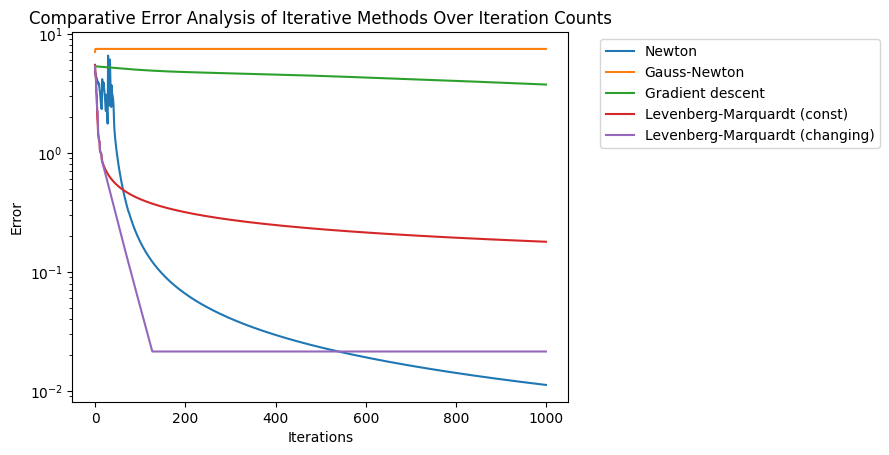

In [66]:
max_iter = 1000
p0 = np.random.randn(M)
alpha_gd = 1e-3
alpha_gn = 1.0
lambda0 = 1.
lambda_change = 1.1
step_max_iter = 10
step_tol = 1e-6

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []
errors_newton = []
log_interval = 1

optimizer = LevenbergMarquardt(
    R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
)
optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, errs=errors_levenberg_marquardt_const_param, log_interval=log_interval)

optimizer = LevenbergMarquardt(
    R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
)
optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol, errs=errors_levenberg_marquardt_modifying_param, log_interval=log_interval)

gauss_newton(R=R, p0=p0, alpha=alpha_gn, max_iter=max_iter, errs=errors_gauss_newton, log_interval=log_interval)
newton(R=R, p0=p0, max_iter=max_iter, alpha=alpha_gn, errs=errors_newton, log_interval=log_interval)
gradient_descent(R=R, p0=p0, alpha=alpha_gd, max_iter=max_iter, errs=errors_gradient_descent, log_interval=log_interval)

iters = np.arange(0, max_iter, log_interval)
for err, label in [
    (errors_newton, "Newton"),
    (errors_gauss_newton, "Gauss-Newton"),
    (errors_gradient_descent, "Gradient descent"),
    (errors_levenberg_marquardt_const_param, "Levenberg-Marquardt (const)"),
    (errors_levenberg_marquardt_modifying_param, "Levenberg-Marquardt (changing)"),
]:
    try:
        plt.plot(iters, err, label=label)
    except:
        print("error in plotting for " + label)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.yscale("log")
plt.title("Comparative Error Analysis of Iterative Methods Over Iteration Counts")
plt.show()